In [2]:
from tools import analysistools as atools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random
from scipy.stats import sem
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from scipy.spatial import distance_matrix
import networkx as nx

from db import databaseconnection as dbc
import sqlalchemy
from sqlalchemy import Table, create_engine, Column, String, PickleType, Integer, Numeric, ForeignKey
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship, backref
from sqlalchemy import *
from sqlalchemy.orm import *
import random
import os
import time
import nanoparticle

import numpy as np
from ga import networkedgeneticalgorithm as nga
from nanoparticle import Ligand, NanoParticle

import colldb
from colldb import Particle, Instance, indToParticle, sessToInst

import argparse

import sys
import collections

In [3]:
dbPath = "/Users/joelforster/Projects/optidb/sep2.db"
Base = declarative_base()
engine = sqlalchemy.create_engine('sqlite:///{}'.format(dbPath))
Base.metadata.create_all(bind=engine)
dbSession = sessionmaker(bind=engine)
dbSession = dbSession()

In [3]:
dbSession.expire_all()
dbSession.flush()

In [4]:
cR = [[20, 13], [20, 14], [21, 12], [21, 13], [21, 14], [22, 12], [22, 13], [22, 14], [23, 10], [23, 11], [23, 12], [23, 13], [24, 10], [24, 11], [24, 12], [24, 13], [25, 9], [25, 10], [25, 11], [25, 12], [26, 9], [26, 10], [26, 11], [27, 9], [27, 10], [28, 9], [28, 10], [29, 8], [29, 9], [30, 8], [30, 9], [31, 7], [31, 8], [32, 7], [32, 8], [33, 7], [33, 8], [34, 7], [35, 6], [35, 7], [36, 6], [37, 6], [38, 6], [39, 6], [40, 6], [42, 5], [43, 5], [44, 5], [45, 5], [46, 5], [50, 4], [51, 4], [52, 4], [53, 4], [54, 4]]


In [5]:
import copy
def pruneNetwork(G,pruning):
    prunes = []
    pruneNodes = []
    GP = copy.deepcopy(G)
    maxW = 0
    if len(G.nodes()) > 0:
        for n,w in G.nodes(data=True):
            if 'weight' not in w or w['weight'] <= 0.0:
                pruneNodes.append(n)

    if len(G.edges()) > 0:
        for e in GP.edges:
            w = GP.get_edge_data(*e)['weight']
            if(w<=pruning):
                prunes.append(e)

    GP.remove_edges_from(prunes)
    GP.remove_nodes_from(pruneNodes)
    return GP

In [6]:
samplesize = 100

bnets = []
nnets = []
for i in dbSession.query(Particle).yield_per(100):
    nL = int(float(i.nligands))
    aE = int(np.round(float(i.avgEps)))

    if not [nL,aE] in cR:
        continue
    if i.budTime > 0 and len(bnets)<samplesize:
        bnets.append(pruneNetwork(i.network,0.3))
    elif len(nnets)<samplesize:
        nnets.append(pruneNetwork(i.network,0.3))
    if len(bnets) >= samplesize and len(nnets) >= samplesize:
        break

/Users/joelforster/anaconda2/lib/python2.7/site-packages/sqlalchemy/sql/sqltypes.py:603: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


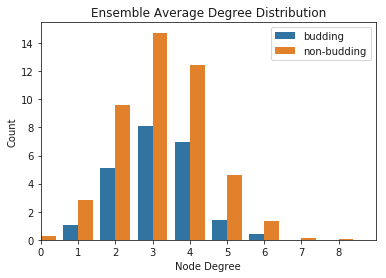

In [87]:
sns.set_color_codes("pastel")
degree_sequence = []
for G in bnets:
    degrees=sorted([d for n, d in G.degree()], reverse=True)
    degree_sequence =degree_sequence +degrees
    
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

df = pd.DataFrame()

cnt = [float(c)/float(samplesize) for c in cnt]

degPad = []
cntPad = []

for i in range(72):
    if not i in deg:
        degPad.append(i)
        cntPad.append(0)
    else:
        degPad.append(i)
        cntPad.append(cnt[deg.index(i)])

        
fig, ax = plt.subplots()

df['degree'] = degPad
df['count'] = cntPad
df['cat'] = ['budding' for d in degPad]


# sns.barplot(x=deg, y =cnt,color='b',label='budding')
#plt.bar([d-0.5 for d in deg], cnt, width=0.50, color='b',label='budding')

for G in nnets:
    degrees=sorted([d for n, d in G.degree()], reverse=True)
    degree_sequence =degree_sequence +degrees
    
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

cnt = [float(c)/float(samplesize) for c in cnt]


degPad = []
cntPad = []

for i in range(72):
    if not i in deg:
        degPad.append(i)
        cntPad.append(0)
    else:
        degPad.append(i)
        cntPad.append(cnt[deg.index(i)])


df2 =pd.DataFrame()

df2['degree'] = degPad
df2['count'] = cntPad
df2['cat'] = ['non-budding' for d in degPad]

df = df.append(df2)

sns.barplot(x='degree', y ='count',hue='cat',data=df)

plt.xlim(0, max(df.query('count > 0.0')['degree'].values)+1)

#plt.bar(list(deg), cnt, width=0.50, color='r',label='non-budding')

plt.title("Ensemble Average Degree Distribution")
plt.ylabel("Count")
plt.xlabel("Node Degree")
ax.set_xticks(deg)
ax.set_xticklabels(deg)
plt.legend()
plt.show()

In [5]:
df = pd.read_csv("/Users/joelforster/Projects/optidb/clus/degs/df.csv") 

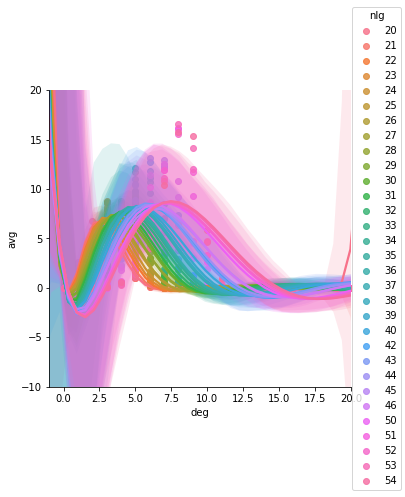

In [72]:
q = df[(df.cat == 'budding')]
qnb = df[(df.cat == 'non budding') & (df.avg > 0.0)]
sns.lmplot('deg', 'avg', data=q, fit_reg=True, hue='nlg',order=10)
plt.xlim(-1,20)
plt.ylim(-10,20)
plt.show()

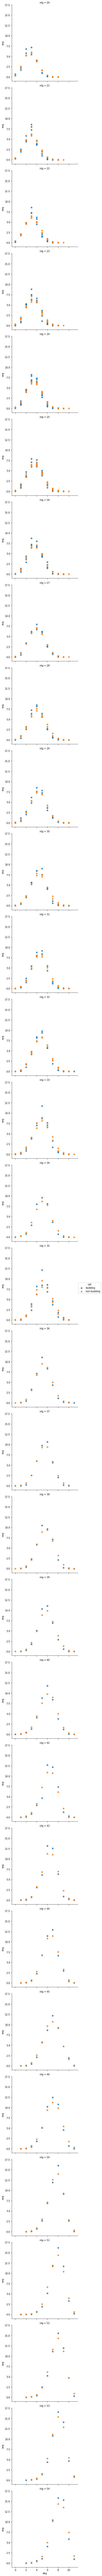

In [137]:
sns.lmplot('deg', 'avg', data=df[df.avg > 0.0], hue='cat',row='nlg',fit_reg=False)
plt.show()